<a href="https://colab.research.google.com/github/ahmedalyfayyad/coloncare_web/blob/main/Colon_Cancer_Detetion_custom_CNN_Histo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd

def load_images_from_folder(base_path):
    valid_exts = ('.jpg', '.jpeg', '.png')
    filepaths, labels = [], []

    for label in os.listdir(base_path):
        label_folder = os.path.join(base_path, label)
        if not os.path.isdir(label_folder):
            continue
        for file in os.listdir(label_folder):
            if file.lower().endswith(valid_exts):
                filepaths.append(os.path.join(label_folder, file))
                labels.append(label)

    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    df['labels'] = df['labels'].astype(str)
    return df

# تحديث المسارات حسب ما ظهر من !ls
base_dir = "/kaggle/input/curated-colon-dataset-for-deep-learning"

train_df = load_images_from_folder(os.path.join(base_dir, "train"))
val_df   = load_images_from_folder(os.path.join(base_dir, "val"))
test_df  = load_images_from_folder(os.path.join(base_dir, "test"))

print(f"✅ Train: {len(train_df)} images | Classes: {train_df['labels'].nunique()}")
print(f"✅ Val:   {len(val_df)} images")
print(f"✅ Test:  {len(test_df)} images")


✅ Train: 3200 images | Classes: 4
✅ Val:   2000 images
✅ Test:  800 images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size
IMG_SIZE = (224, 224)

# Augmentation للـ training فقط
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

# توليد البيانات
train_generator = train_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_generator = val_gen.flow_from_dataframe(
    val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_generator = test_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 3200 validated image filenames belonging to 4 classes.
Found 2000 validated image filenames belonging to 4 classes.
Found 800 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 2
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 3
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 4
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Output
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749509400.372526      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749509400.373314      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 423,748 (1.62 MB)

 Trainable params: 422,788 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1749509437.565142     102 service.cc:148] XLA service 0x7da4681193f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749509437.565979     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749509437.566000     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749509438.135232     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.3516 - loss: 1.6752  

I0000 00:00:1749509444.798541     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 111s 996ms/step - accuracy: 0.7039 - loss: 0.7482 - val_accuracy: 0.2500 - val_loss: 1.6676 - learning_rate: 1.0000e-04
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 631ms/step - accuracy: 0.8551 - loss: 0.3657 - val_accuracy: 0.2500 - val_loss: 2.0430 - learning_rate: 1.0000e-04
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 625ms/step - accuracy: 0.9075 - loss: 0.2562 - val_accuracy: 0.2510 - val_loss: 1.6520 - learning_rate: 1.0000e-04
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 625ms/step - accuracy: 0.9280 - loss: 0.2008 - val_accuracy: 0.5685 - val_loss: 1.2060 - learning_rate: 1.0000e-04
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 619ms/step - accuracy: 0.9399 - loss: 0.1914 - val_accuracy: 0.6365 - val_loss: 1.1591 - learning_rate: 1.0000e-04
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 627ms/step - accuracy: 0.9489 - loss: 0.1623 - val_accuracy: 0.7135 - val_loss: 0.9588 - learning_rate: 1.0000e-04
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 630ms/step -

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 260ms/step


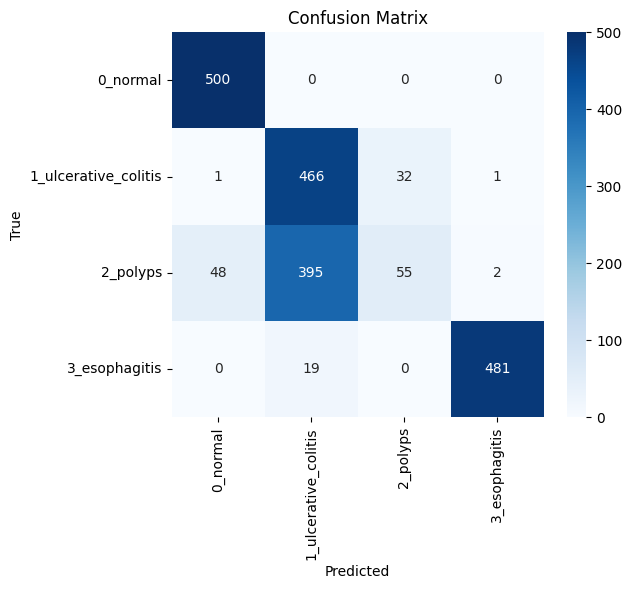

                      precision    recall  f1-score   support

            0_normal       0.91      1.00      0.95       500
1_ulcerative_colitis       0.53      0.93      0.68       500
            2_polyps       0.63      0.11      0.19       500
       3_esophagitis       0.99      0.96      0.98       500

            accuracy                           0.75      2000
           macro avg       0.77      0.75      0.70      2000
        weighted avg       0.77      0.75      0.70      2000



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# التوقعات على مجموعة التحقق
val_preds = model.predict(val_generator, verbose=1)
pred_classes = np.argmax(val_preds, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(true_classes, pred_classes, target_names=class_labels))


In [ ]:
train_df['labels'].value_counts()


labels
0_normal                800
2_polyps                800
3_esophagitis           800
1_ulcerative_colitis    800
Name: count, dtype: int64

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import random
import shutil

augmentor = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)


In [ ]:
target_class = '2_polyps'
source_dir = '/kaggle/input/curated-colon-dataset-for-deep-learning/train/' + target_class
dest_dir = '/kaggle/working/augmented/train/' + target_class
os.makedirs(dest_dir, exist_ok=True)

images = os.listdir(source_dir)
for img_name in random.sample(images, 100):  # عدد الصور المعززة
    img = load_img(os.path.join(source_dir, img_name))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    i = 0
    for batch in augmentor.flow(x, batch_size=1, save_to_dir=dest_dir, save_prefix='aug', save_format='jpg'):
        i += 1
        if i >= 5:
            break


In [ ]:
import pandas as pd
from pathlib import Path

# 1️⃣ Define the path to augmented images
train_path = Path("/kaggle/working/augmented/train/2_polyps")

# 2️⃣ Collect all image file paths
filepaths = list(train_path.rglob("*.jpg"))

# 3️⃣ Create a DataFrame with file paths and labels
train_df = pd.DataFrame({
    'filepaths': filepaths
})
train_df['filepaths'] = train_df['filepaths'].astype(str)  # Convert to string
train_df['labels'] = train_df['filepaths'].apply(lambda x: Path(x).parent.name)

# 4️⃣ Define ImageDataGenerator (you can customize augmentation here)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# 5️⃣ Load images using flow_from_dataframe
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)


Found 489 validated image filenames belonging to 1 classes.


In [ ]:
import pandas as pd
from pathlib import Path

# المسار إلى الصور اللي فيها normal
normal_path = Path("/kaggle/input/curated-colon-dataset-for-deep-learning/val/0_normal")

# جمع المسارات في DataFrame
normal_df = pd.DataFrame({
    'filepaths': list(normal_path.rglob("*.jpg"))
})
normal_df['labels'] = '0_normal'


In [ ]:
# المسار إلى صور polyps (اللي جهزناهم بالفعل)
polyps_path = Path("/kaggle/working/augmented/train/2_polyps")

polyps_df = pd.DataFrame({
    'filepaths': list(polyps_path.rglob("*.jpg"))
})
polyps_df['labels'] = '2_polyps'


In [ ]:
from sklearn.utils import shuffle

# دمج الاتنين
binary_df = pd.concat([normal_df, polyps_df], ignore_index=True)
binary_df = shuffle(binary_df).reset_index(drop=True)

# تحويل المسارات إلى strings
binary_df['filepaths'] = binary_df['filepaths'].astype(str)


In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=binary_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=binary_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='validation',
    shuffle=True
)


Found 792 validated image filenames belonging to 2 classes.
Found 197 validated image filenames belonging to 2 classes.


In [ ]:
print(binary_df['labels'].value_counts())


labels
0_normal    500
2_polyps    489
Name: count, dtype: int64


In [ ]:
df = df[df['labels'].isin(['0_normal', '2_polyps'])].reset_index(drop=True)
print(df['labels'].value_counts())
print(len(df))


Series([], Name: count, dtype: int64)
0


In [ ]:
from pathlib import Path
import pandas as pd

# تحديث المسار للمجلد الجديد اللي فيه الصور
train_path = Path("/kaggle/working/augmented/train/2_polyps")

# إنشاء DataFrame من الصور داخل الفولدر
filepaths = list(train_path.rglob("*.jpg"))
df = pd.DataFrame({'filepaths': [str(p) for p in filepaths]})
df['labels'] = df['filepaths'].apply(lambda x: Path(x).parent.name)
df['encoded_labels'] = df['labels'].astype('category').cat.codes

print(df['labels'].value_counts())


labels
2_polyps    489
Name: count, dtype: int64


In [ ]:
print(df['filepaths'].head())


0    /kaggle/working/augmented/train/2_polyps/aug_0...
1    /kaggle/working/augmented/train/2_polyps/aug_0...
2    /kaggle/working/augmented/train/2_polyps/aug_0...
3    /kaggle/working/augmented/train/2_polyps/aug_0...
4    /kaggle/working/augmented/train/2_polyps/aug_0...
Name: filepaths, dtype: object


In [ ]:
from pathlib import Path
import pandas as pd

# المسار الرئيسي لمجلد التدريب
base_path = Path("/kaggle/input/curated-colon-dataset-for-deep-learning/train")

# جمع كل مسارات الصور داخل كل الكلاسات
filepaths = list(base_path.rglob("*.jpg"))

# بناء الداتا فريم
df = pd.DataFrame({
    'filepaths': [str(p) for p in filepaths],
    'labels': [p.parent.name for p in filepaths]
})

# Encode labels
df['encoded_labels'] = df['labels'].astype('category').cat.codes

# تأكد من التوزيع
print(df['labels'].value_counts())
df.head()


labels
0_normal                800
2_polyps                800
3_esophagitis           800
1_ulcerative_colitis    800
Name: count, dtype: int64


,filepaths,labels,encoded_labels
0,/kaggle/input/curated-colon-dataset-for-deep-l...,0_normal,0
1,/kaggle/input/curated-colon-dataset-for-deep-l...,0_normal,0
2,/kaggle/input/curated-colon-dataset-for-deep-l...,0_normal,0
3,/kaggle/input/curated-colon-dataset-for-deep-l...,0_normal,0
4,/kaggle/input/curated-colon-dataset-for-deep-l...,0_normal,0


In [ ]:
from sklearn.model_selection import train_test_split

# Train/Test split بنسبة 60/20/20
train_df, temp_df = train_test_split(df, stratify=df['encoded_labels'], test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, stratify=temp_df['encoded_labels'], test_size=0.5, random_state=42)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Train: 1920 | Val: 640 | Test: 640


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                              target_size=(224, 224), class_mode='categorical', batch_size=32, shuffle=True)
val_gen = val_datagen.flow_from_dataframe(val_df, x_col='filepaths', y_col='labels',
                                          target_size=(224, 224), class_mode='categorical', batch_size=32, shuffle=False)
test_gen = val_datagen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                           target_size=(224, 224), class_mode='categorical', batch_size=32, shuffle=False)


Found 1920 validated image filenames belonging to 4 classes.
Found 640 validated image filenames belonging to 4 classes.
Found 640 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # عدد الكلاسات = 4
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 423,748 (1.62 MB)

 Trainable params: 422,788 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 589ms/step - accuracy: 0.7286 - loss: 0.6846 - val_accuracy: 0.2719 - val_loss: 1.2200 - learning_rate: 0.0010
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 565ms/step - accuracy: 0.8965 - loss: 0.2641 - val_accuracy: 0.2516 - val_loss: 1.2800 - learning_rate: 0.0010
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 561ms/step - accuracy: 0.9245 - loss: 0.2409 - val_accuracy: 0.3422 - val_loss: 1.1768 - learning_rate: 0.0010
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 557ms/step - accuracy: 0.9209 - loss: 0.2175 - val_accuracy: 0.4609 - val_loss: 1.4846 - learning_rate: 0.0010
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 550ms/step - accuracy: 0.9174 - loss: 0.2404 - val_accuracy: 0.6875 - val_loss: 0.7190 - learning_rate: 0.0010
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 559ms/step - accuracy: 0.9323 - loss: 0.1999 - val_accuracy: 0.4922 - val_loss: 1.3758 - learning_rate: 0.0010
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 546ms/step - accuracy: 0.9363 - loss: 0.

25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 504ms/step
Classification Report:

                      precision    recall  f1-score   support

            0_normal       0.90      1.00      0.95       200
1_ulcerative_colitis       0.56      0.92      0.69       200
            2_polyps       0.88      0.21      0.34       200
       3_esophagitis       0.99      1.00      1.00       200

            accuracy                           0.78       800
           macro avg       0.83      0.78      0.74       800
        weighted avg       0.83      0.78      0.74       800



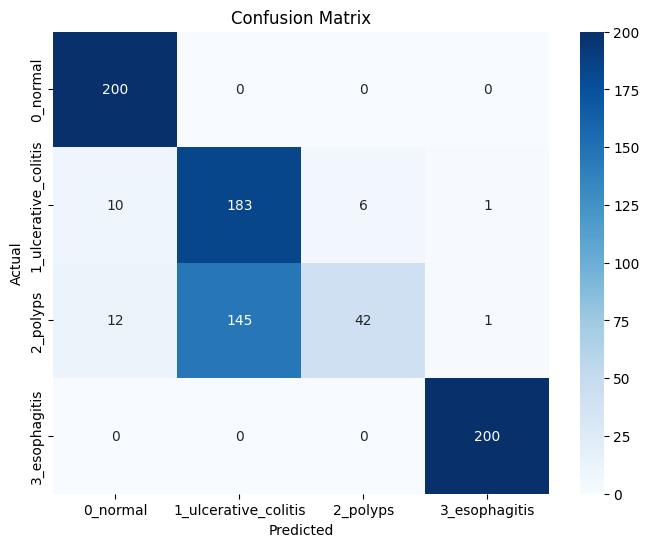

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Predict on test set
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Generate report
labels_names = list(test_generator.class_indices.keys())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels_names))

# Step 3: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_names, yticklabels=labels_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # لأننا هنستخدم categorical_crossentropy
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 1920 validated image filenames belonging to 4 classes.
Found 640 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 299ms/step - accuracy: 0.6685 - loss: 0.8448 - val_accuracy: 0.2500 - val_loss: 1.4135 - learning_rate: 1.0000e-04
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 276ms/step - accuracy: 0.8769 - loss: 0.3468 - val_accuracy: 0.2500 - val_loss: 1.5688 - learning_rate: 1.0000e-04
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8922 - loss: 0.2915
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 278ms/step - accuracy: 0.8922 - loss: 0.2915 - val_accuracy: 0.2500 - val_loss: 1.7162 - learning_rate: 1.0000e-04
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 279ms/step - accuracy: 0.9143 - loss: 0.2463 - val_accuracy: 0.2500 - val_loss: 1.6139 - learning_rate: 5.0000e-05
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9325 - loss: 0.1939
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 282ms/step - accuracy: 0.932

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {acc:.4f} | Test Loss: {loss:.4f}")


Found 640 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - accuracy: 0.9868 - loss: 0.0591
✅ Test Accuracy: 0.9812 | Test Loss: 0.0762


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step
                      precision    recall  f1-score   support

            0_normal       0.99      0.99      0.99       160
1_ulcerative_colitis       0.96      0.98      0.97       160
            2_polyps       0.99      0.95      0.97       160
       3_esophagitis       0.99      1.00      0.99       160

            accuracy                           0.98       640
           macro avg       0.98      0.98      0.98       640
        weighted avg       0.98      0.98      0.98       640



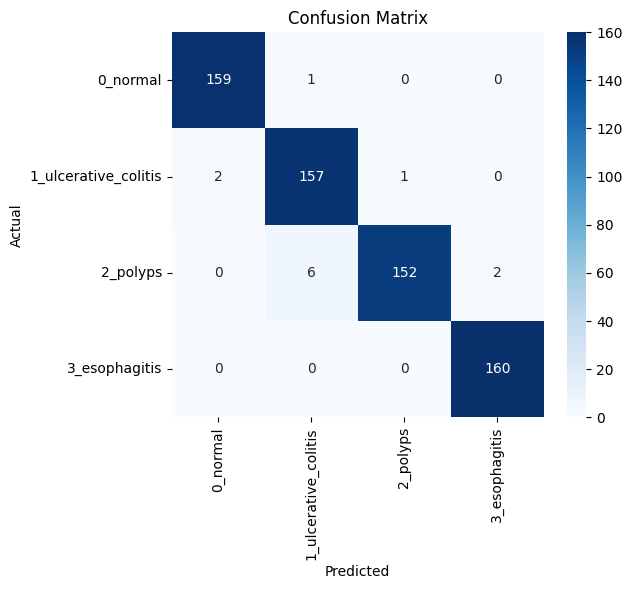

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# True labels
y_true = test_generator.classes

# Predictions
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save("colon_disease_classifier.h5")
